# Statistical analysis

Statistics helps us make sense of data by summarizing patterns, testing hypotheses, and modeling relationships. They are mostly used to investigate the process that have generated the data, what can be associated with a *detective* mode. This notebook covers three essential statistical approaches with `tangent/ds`.

- Descriptive statistics summarize and describe your data.
- Hypothesis testing creates probabilistic statistics, in *frequential* mode.
- Linear models establishes relationships between variables.

While ordination methods (PCA, LDA, RDA) help us visualize patterns, statistics helps us

- to quantify uncertainty,
- to test probabilities on patterns,
- to model relationships between variables

If the aim is to *predict* outcomes, you might prefer machine learning.

In [1]:
// Setup DOM for plotting in Jupyter with Deno
import { Window } from 'https://esm.sh/happy-dom@12.10.3';
const window = new Window();
globalThis.document = window.document;
globalThis.HTMLElement = window.HTMLElement;

// import packages
import * as ds from '../../src/index.js';
import * as Plot from '@observablehq/plot';

// data
const penguinsResponse = await fetch(
  'https://cdn.jsdelivr.net/npm/vega-datasets@2/data/penguins.json',
);
const penguinsDataRaw = await penguinsResponse.json();
const penguinsData = penguinsDataRaw // there is a row with a "." instead of null in the Sex field
  .map(row => row.Sex === '.' ? { ...row, Sex: null } : row)
  .filter(row => row.Sex);

console.table(penguinsData.slice(0, 5));

┌───────┬──────────┬─────────────┬──────────────────┬─────────────────┬─────────────────────┬───────────────┬──────────┐
│ (idx) │ Species  │ Island      │ Beak Length (mm) │ Beak Depth (mm) │ Flipper Length (mm) │ Body Mass (g) │ Sex      │
├───────┼──────────┼─────────────┼──────────────────┼─────────────────┼─────────────────────┼───────────────┼──────────┤
│     0 │ "Adelie" │ "Torgersen" │ 39.1             │ 18.7            │ 181                 │ 3750          │ "MALE"   │
│     1 │ "Adelie" │ "Torgersen" │ 39.5             │ 17.4            │ 186                 │ 3800          │ "FEMALE" │
│     2 │ "Adelie" │ "Torgersen" │ 40.3             │ 18              │ 195                 │ 3250          │ "FEMALE" │
│     3 │ "Adelie" │ "Torgersen" │ 36.7             │ 19.3            │ 193                 │ 3450          │ "FEMALE" │
│     4 │ "Adelie" │ "Torgersen" │ 39.3             │ 20.6            │ 190                 │ 3650          │ "MALE"   │
└───────┴──────────┴────────────

## Descriptive statistics

Descriptive statistics summarize data with a few key numbers, usually central tendency like mean or median, and the spread like standard deviatio, quantiles and ranges.

In [2]:
const beakLength = penguinsData.map(d => d["Beak Length (mm)"])

In [3]:
ds.core.math.mean(beakLength, { naOmit: true })

43.992792792792805

In [4]:
ds.core.math.stddev(beakLength, { naOmit: true })

5.468668342647562

In [5]:
ds.core.math.quantile(beakLength, [0.25, 0.5, 0.75], { naOmit: true })

[ 39.5, 44.5, 48.6 ]

### Grouped statistics with Arquero

The [Arquero package](https://observablehq.com/@uwdata/introducing-arquero) provides a declarative approach for computing statistics by group (similar to dplyr in R or pandas in Python). This is especially useful when you want to compare statistics across categories.

In [6]:
const aq = await import('https://cdn.jsdelivr.net/npm/arquero@latest/+esm');

In [7]:
const penguinsTable = aq.from(penguinsData);

In [8]:
void penguinsTable
  .groupby('Species')
  .rollup({
    min:  d => op.min(d["Beak Length (mm)"]), // functional form of op.min('sun')
    max:  d => op.max(d["Beak Length (mm)"]),
    mean:  d => op.average(d["Beak Length (mm)"]),
    median:  d => op.median(d["Beak Length (mm)"]),
    sd:  d => op.stdev(d["Beak Length (mm)"]),
  })
  .print()

Table: 6 cols x 3 rows. Showing 3 rows.
┌───────┬─────────────┬──────┬──────┬───────────────────┬────────────────────┬────────────────────┐
│ (idx) │ Species     │ min  │ max  │ mean              │ median             │ sd                 │
├───────┼─────────────┼──────┼──────┼───────────────────┼────────────────────┼────────────────────┤
│     0 │ "Adelie"    │ 32.1 │ 46   │ 38.82397260273972 │ 38.849999999999994 │ 2.6625967308190606 │
│     1 │ "Chinstrap" │ 40.9 │ 58   │ 48.83382352941176 │ 49.55              │ 3.339255895935887  │
│     2 │ "Gentoo"    │ 40.9 │ 59.6 │ 47.56806722689077 │ 47.4               │ 3.106115694449684  │
└───────┴─────────────┴──────┴──────┴───────────────────┴────────────────────┴────────────────────┘


## Hypothesis testing

Hypothesis testing answers a statistical question. Ready for some jargon? The *statistical model* is the tool used for the test (t-test, anova, glm, etc.), and how the analyst designed the model. The *null hypothesis* (H₀) generally assumes the statu quo, that the action like a treatment has no effect in the population. The *alternative hypothesis* (H₁) assumes the complementary, that the action has sn effect in the population. Both H₀ and H₁ are valid only in the frame of the statistical model. A *test statistic* computes a number measuring the effect.

The *p-value* is an important test statistic. It's the probability that the sample was taken from a population under H₀.

- **P-value ≠ probability that H₀ is true**.
- P-values depend a lot on sample size. Since larger data sets generate smaller p-values, significance (when p-value < 0.05) doesn't mean variable importance.
- Always report effect sizes and confidence intervals, never just p-values - which are accessory.
- The p-value threshold of 0.05 is arbitrary.

Our Question: Do penguin species differ in body bass? Let's test if Adelie, Chinstrap, and Gentoo penguins have different average body masses by first extracting them.

In [9]:
const tested_variable = "Body Mass (g)";
const adelie_var = penguinsData
  .filter((d) => d.Species == "Adelie")
  .map((d) => d[tested_variable]);
const chinstrap_var = penguinsData
  .filter((d) => d.Species == "Chinstrap")
  .map((d) => d[tested_variable]);
const gentoo_var = penguinsData
  .filter((d) => d.Species == "Gentoo")
  .map((d) => d[tested_variable]);

## T-test

A t-test compares means of two groups. The null hypothesis is that the two groups have the same mean. Let's compare Adelie vs Gentoo body mass to test if they are different (a two-sided test). If the test was about sample 1 being less than sample 2, the alternative hypothesis would be `less`.

In [10]:
const ttest = ds.stats.hypothesis.twoSampleTTest(adelie_var, gentoo_var, { alternative: 'two-sided' })
console.table(ttest);

┌─────────────┬───────────────────────┐
│ (idx)       │ Values                │
├─────────────┼───────────────────────┤
│ statistic   │ -23.466803147391744   │
│ pValue      │ 0.0020000000000000018 │
│ df          │ 263                   │
│ mean1       │ 3706.1643835616437    │
│ mean2       │ 5092.436974789916     │
│ pooledSE    │ 59.07377253396154     │
│ alternative │ "two-sided"           │
└─────────────┴───────────────────────┘


Interpreting the T-Test results:

- **statistic = -23.5**: Large negative value → Adelie mean < Gentoo mean
- **pValue ≈ 0.002**: Very small → Evidence against H₀
- **mean1 = 3606g, mean2 = 5092g**: Gentoo penguins are ~1359g heavier!
- **Conclusion**: Adelie and Gentoo penguins have significantly different body masses

## ANOVA

Although its name refers to variance, ANOVA (analysis of variance) tests H₀, assuming samples from multiple groups are drawn from populations sharing the same mean. If the groups differ, the variance *between* groups should be large compared to the variance *within* groups. This comparison is where the variance aspect of ANOVA comes into play. When we are comparing *one* feature (e.g., body mass) across groups (e.g., different species), we perform a *one*-way ANOVA. ANOVA can be extended to two-way, three-way, and even higher (e.g., seven-hundred ninety-nine-way ANOVA) depending on how many factors are involved. Each additional factor complicates the analysis and adds more interaction terms to consider. This highlights the fact that ANOVA can be viewed as a case of linear regression when the target variable is categorical. In essence, it assesses how well categorical predictors help explain the variability in the response variable.

In [11]:
const anova = ds.stats.hypothesis.oneWayAnova([adelie_var, chinstrap_var, gentoo_var]);
console.table(anova);

┌───────────┬────────────────────┐
│ (idx)     │ Values             │
├───────────┼────────────────────┤
│ statistic │ 341.89489494814654 │
│ pValue    │ 0                  │
│ dfBetween │ 2                  │
│ dfWithin  │ 330                │
│ MSbetween │ 72595109.55661117  │
│ MSwithin  │ 212331.6569778595  │
└───────────┴────────────────────┘


Interpreting ANOVA results:

- **statistic (F) ≈ 342**, very large → strong between-group differences
- **pValue ≈ 0**, essentially zero → overwhelming evidence of differences
- **MSbetween vs MSwithin**, between-group variance is ~218× larger than within-group
- **Conclusion**: at least one species differs significantly from the others. ANOVA tells us groups differ, but not *which* groups. For that, we'd need post-hoc tests (e.g., Tukey HSD).

## Tukey

The ANOVA indicated significant differences exist, and Tukey's test identifies which specific pairs differ by doing a collection of pairwise t-tests.

In [24]:
const anova = ds.stats.hypothesis.oneWayAnova([adelie_var, chinstrap_var, gentoo_var]);
const tukey = ds.stats.hypothesis.tukeyHSD({Adelie: adelie_var, Chintrap: chinstrap_var, Gentoo: gentoo_var}, { alpha: 0.05, anovaResult: anova })
tukey;

{
  comparisons: [
    {
      groups: [ 0, 1 ],
      groupLabels: [ "Adelie", "Chintrap" ],
      diff: -26.92385173247385,
      lowerCI: -255.79423652991656,
      upperCI: 201.94653306496886,
      pValue: 0.999999,
      significant: false,
      qStatistic: 0.5628190790914845
    },
    {
      groups: [ 0, 2 ],
      groupLabels: [ "Adelie", "Gentoo" ],
      diff: -1386.2725912282726,
      lowerCI: -1578.7973667732513,
      upperCI: -1193.747815683294,
      pValue: 0.001998999999999973,
      significant: true,
      qStatistic: 34.44952448825263
    },
    {
      groups: [ 1, 2 ],
      groupLabels: [ "Chintrap", "Gentoo" ],
      diff: -1359.3487394957988,
      lowerCI: -1596.3258848252844,
      upperCI: -1122.3715941663131,
      pValue: 0.001998999999999973,
      significant: true,
      qStatistic: 27.443888487586864
    }
  ],
  groupMeans: [ 3706.1643835616437, 3733.0882352941176, 5092.436974789916 ],
  groupNames: [ "Adelie", "Chintrap", "Gentoo" ],
  MSwithin: 

The Tukey test results returns important information on group means, showing that gentoos are much larger. Remember that the test is not about the importance of the difference, but the importance of the variation around the differences. In the context of bird species, although, it would be surprising to find so much variance in body mass (this prior knowledge isn't included in the statistical model, to do so we would need bayesian statistics, which `tangent/ds` isn't equipped to do yet). The pairwise test between adelie and chinstrap shows to be small with a confidence interval crossing the zero widelybetween -256 and +202 g, with a mean of -26.92 g. The test shows that the mass of both populations are likely drawn from populations with similar means of body masses. However, the difference between gentoo and adelie, and between gentoo and chinstrap are far from crossing zero. Data shows that gentoo penguins are substantially heavier than both adelie and chinstrap penguins, while adelie and chinstrap penguins have similar body masses.

## Linear models

Linear models describe relationships between variables as $y = β₀ + β₁x₁ + β₂x₂ + ... + ε$. A Generalized Linear Model (GLM) extends classical linear regressions with a continuous `y` to different types of response variables.

| Type | Family | Link | Use For |
|------|--------|------|----------|
| Linear Regression | gaussian | identity | Continuous Y |
| Logistic Regression | binomial | logit | Binary Y (0/1) |
| Poisson Regression | poisson | log | Count Y (0,1,2,...) |

In `tangent/ds`, all linear models use the `GLM` class - you just specify the family and link function.

### Simple linear regression

Let's model the relationship between beak length and body mass, asking does beak length predict body mass under $Body~mass = β₀ + β₁ × Beak~length + ε$

We use `family: 'gaussian'` (normal distribution) and `link: 'identity'` (direct linear relationship).

In [27]:
const simple_lm = new ds.stats.GLM({family: 'gaussian', link: 'identity'});
simple_lm.fit({
  X: "Beak Length (mm)",
  y: 'Body Mass (g)',
  data: penguinsData,
});
console.log(simple_lm.summary({ alpha: 0.05 })); // use console.log() for a prettier output


Generalized Linear Model
Family: gaussian, Link: identity

Coefficients:
                  Estimate  Std.Error  z value    95% CI
(Intercept)        388.845159 289.817203    1.342  [-179.186, 956.876]
Beak Length (mm)    86.791760   6.537666   13.276  [73.978, 99.605]

Null Deviance: 215259665.9159 on 332 degrees of freedom
Residual Deviance: 140467132.8883 on 331 degrees of freedom
AIC: 5262.15
BIC: 5269.77
Dispersion: 424372.0027
Pseudo R²: 0.3475
Iterations: 2, Converged: true



The `Estimate` column are the values of $β_p$. The `(Intercept)` of 388.8* is the value of $β_0$, the body mass when beak length = 0. Having a beak length of 0 in an extrapolation of the domain, and the intercept is not meaningful here. The `Estimate` of beak length is the slope, of `87.4`.  This means that for each 1 mm increase in beak length, body mass increases by ~87g. The `95% CI = [74.9, 100.0]` is the confidence range of the effect of beak length. We are 95% confident that the slope of the population is in this range, and the CI doesn't cross 0. The slope estimate depends on the scale at which variables are expressed, so they can't be compared one to another. Z-value are standardized, and can be use to compare the importance of variables in a GLM - here we just have two estimates. The pseudo R² of 0.354 tells us that beak length explains 35.4% of variance in body mass. Interpreting if it's high or low really depends on the use case. AIC/BIC are mostly use to compare models one to another. Not so useful if the definition of the model is fixed, but useful to assess the features we might want to drop. The model tells us that penguins with longer beaks tend to be heavier. But R² = 0.354 is far from 1 and means beak length alone isn't the whole story.

#### About P-values

By default, the summary doesn't show p-values. This is intentional, because [p-values are notoriously misused](https://en.wikipedia.org/wiki/Misuse_of_p-values). Focus on:
1. Effect sizes (coefficients)
2. Confidence intervals
3. R² (variance explained)

But if you need them, they're computed silently:

In [28]:
simple_lm.pvalues();

[ 0.17969626906126357, 0 ]

#### Making predictions

Once we have a fitted model, we can predict new values. Let's predict body mass for a penguin with a 40 mm beak.

In [29]:
simple_lm.predict({
  X: "Beak Length (mm)",
  data: [{"Beak Length (mm)": 40}]
});

[ 3860.515544662456 ]

Predictions are useful to plot the GLM.

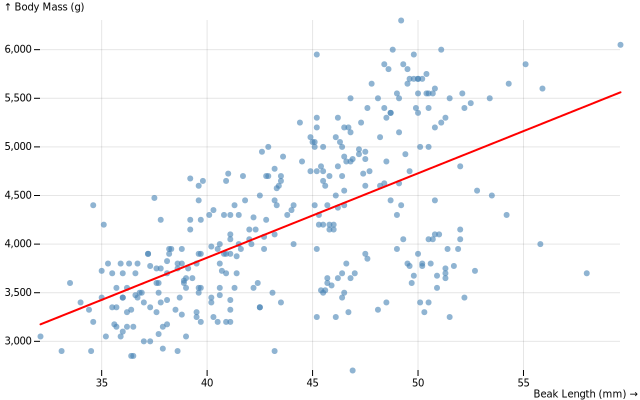

In [30]:
// Get min and max, automatically omitting NaN/null/undefined
const xMin = ds.core.math.min(penguinsData.map(d => d["Beak Length (mm)"]), { naOmit: true });
const xMax = ds.core.math.max(penguinsData.map(d => d["Beak Length (mm)"]), { naOmit: true });

// Generate sequence for prediction
const xValues = ds.core.math.range(xMin, xMax, 0.5).map(x => ({
  "Beak Length (mm)": x
}));

// predict
const predictions = lm.predict({
  X: "Beak Length (mm)",
  data: xValues
});

// Combine x values with predictions
const lineData = xValues.map((d, i) => ({
  x: d["Beak Length (mm)"],
  y: predictions[i]
}));

// Create the plot
const plot = Plot.plot({
  marks: [
    // Scatter plot of actual data
    Plot.dot(penguinsData, {
      x: "Beak Length (mm)",
      y: "Body Mass (g)",
      fill: "steelblue",
      opacity: 0.6
    }),
    // Regression line
    Plot.line(lineData, {
      x: "x",
      y: "y",
      stroke: "red",
      strokeWidth: 2
    })
  ],
  grid: true,
  x: { label: "Beak Length (mm)" },
  y: { label: "Body Mass (g)" }
});
plot;


### Categorical Target

When the target variable is categorical (e.g., species), we use **logistic regression** instead of linear regression. Logistic models differ from gaussian models in several ways.

- **Family**: `binomial` instead of `gaussian`
- **Link function**: `logit` transforms probabilities to log-odds: `logit(p) = log(p / (1-p))`
- **Output**: Probabilities between 0 and 1 (after inverse-logit)
- **Interpretation**: Coefficients represent change in log-odds, not raw values

To perform categorical linear models, we use a multiclass strategy. For 3 or more classes (like Adelie, Chinstrap, Gentoo), we use a one-vs-rest (OVR) model:

- Fit 3 separate binary models: "Is Adelie?", "Is Chinstrap?", "Is Gentoo?".
- Each model predicts probability of being that class vs all others.
- Final prediction: class with highest probability.

Categorical variables must be converted to numbers (one-hot encoding).

In [34]:
const encoder = new ds.core.table.OneHotEncoder();
const encoded = encoder.fitTransform({
    data: penguinsData,
    columns: ["Species", "Sex"]
});
const penguinsWithOneHot = penguinsData.map((row, i) => ({
    ...row,
    ...encoded[i]
}));
console.table(penguinsWithOneHot.slice(0, 6));

┌───────┬──────────┬─────────────┬──────────────────┬─────────────────┬─────────────────────┬───────────────┬──────────┬────────────────┬───────────────────┬────────────────┬──────────┬────────────┐
│ (idx) │ Species  │ Island      │ Beak Length (mm) │ Beak Depth (mm) │ Flipper Length (mm) │ Body Mass (g) │ Sex      │ Species_Adelie │ Species_Chinstrap │ Species_Gentoo │ Sex_MALE │ Sex_FEMALE │
├───────┼──────────┼─────────────┼──────────────────┼─────────────────┼─────────────────────┼───────────────┼──────────┼────────────────┼───────────────────┼────────────────┼──────────┼────────────┤
│     0 │ "Adelie" │ "Torgersen" │ 39.1             │ 18.7            │ 181                 │ 3750          │ "MALE"   │ 1              │ 0                 │ 0              │ 1        │ 0          │
│     1 │ "Adelie" │ "Torgersen" │ 39.5             │ 17.4            │ 186                 │ 3800          │ "FEMALE" │ 1              │ 0                 │ 0              │ 0        │ 1          │
│    

In [35]:
const model = new ds.stats.GLM({
  family: "binomial",
  multiclass: "ovr" // use ovr for a collection of binomial regressions with one group versus others, and multinomial to predict class assignment probabilities
});

model.fit({
  X: ["Beak Length (mm)", "Beak Depth (mm)", "Flipper Length (mm)", "Body Mass (g)", "Sex_FEMALE"], // use only one Sex_ variable since categories has d-1 information, since male is non-female.
  y: "Species", // don't use multiple target with ovr
  data: penguinsWithOneHot // it will get the Species_ columns
});
model

ℹ️  Multiclass: Fitting 3 binary models using one-vs-rest strategy.



Multiclass GLM (One-vs-Rest)
Family: binomial, Link: logit
Classes: Adelie, Chinstrap, Gentoo
Number of binary models: 3

Model for class: Adelie (vs rest)

Generalized Linear Model
Family: binomial, Link: logit

Coefficients:
                     Estimate  Std.Error  z value    95% CI
(Intercept)           784.321729 98138.825435    0.008  [-191564.241, 193132.885]
Beak Length (mm)      -52.318778 985.591461   -0.053  [-1984.043, 1879.405]
Beak Depth (mm)        84.443216 2604.271950    0.032  [-5019.836, 5188.722]
Flipper Length (mm)    -0.592347 421.568713   -0.001  [-826.852, 825.667]
Body Mass (g)           0.036267   6.672900    0.005  [-13.042, 13.115]
Sex_FEMALE            -68.025605 8922.843059   -0.008  [-17556.477, 17420.425]

Null Deviance: 456.5751 on 332 degrees of freedom
Residual Deviance: 0.0000 on 327 degrees of freedom
AIC: 12.00
BIC: 34.85
Dispersion: 1.0000
Pseudo R²: 1.0000
Iterations: 77, Converged: true

Model for class: Chinstrap (vs rest)

Generalized Linear 

### Mixed-effects models, aka hierarchical models

Sometimes data has nested structure or grouping which are defined by the research methodology, not but the property of the studied object. The difference between a fixed and a random effect is that the sum of all random effect is forced to be null. A model structure to test for yield against barley's variety and year with site as random effect could be expressed as

$yield = β₀ + β₁·variety + u_{site} + ε$

where:
- $β₀, β₁$ = fixed intercept and slopes (same for all sites)
- $u_{site}$ = random intercept for each site (allows baseline yield to vary by site)
- $ε$ = residual error

In [19]:
const response = await fetch('https://cdn.jsdelivr.net/npm/vega-datasets@2/data/barley.json');
const barleyData = await response.json();
console.table(barleyData.slice(0, 6));

┌───────┬──────────┬─────────────┬──────┬───────────────────┐
│ (idx) │ yield    │ variety     │ year │ site              │
├───────┼──────────┼─────────────┼──────┼───────────────────┤
│     0 │ 27       │ "Manchuria" │ 1931 │ "University Farm" │
│     1 │ 48.86667 │ "Manchuria" │ 1931 │ "Waseca"          │
│     2 │ 27.43334 │ "Manchuria" │ 1931 │ "Morris"          │
│     3 │ 39.93333 │ "Manchuria" │ 1931 │ "Crookston"       │
│     4 │ 32.96667 │ "Manchuria" │ 1931 │ "Grand Rapids"    │
│     5 │ 28.96667 │ "Manchuria" │ 1931 │ "Duluth"          │
└───────┴──────────┴─────────────┴──────┴───────────────────┘


The variety being a category, it must be encoded.

In [39]:
const barleyEncoder = new ds.core.table.OneHotEncoder();
const barleyVarietyEncoded = barleyEncoder.fitTransform({
    data: barleyData,
    columns: ["variety"]
});
const barleyDataEncoded = barleyData.map((row, i) => ({
    ...row,
    ...barleyVarietyEncoded[i]
}));
barleyDataEncoded[50];

{
  yield: 22.6,
  variety: "No. 475",
  year: 1931,
  site: "Morris",
  variety_Manchuria: 0,
  variety_Glabron: 0,
  variety_Svansota: 0,
  variety_Velvet: 0,
  variety_Trebi: 0,
  "variety_No. 457": 0,
  "variety_No. 462": 0,
  variety_Peatland: 0,
  "variety_No. 475": 1,
  "variety_Wisconsin No. 38": 0
}

The features of the models are the different varieties, except the extra information provided by one of them (if all otehrs are zeros, than we know it's the removed one, no need to argue on that). We remove `variety_Manchuria`, used as the reference, the one used for the intercept.

In [43]:
const featuresArray = [
  "variety_Glabron",
  "variety_Svansota",
  "variety_Velvet",
  "variety_Trebi",
  "variety_No. 457",
  "variety_No. 462",
  "variety_Peatland",
  "variety_No. 475",
  "variety_Wisconsin No. 38"
]

Mixed effects models use the same GLM API we used yet, but adding a `randomEffects` argument. Here we consider that the methodological effect of sites is on the intercept, supposing they have a simple additive effect on yield.

In [22]:
const sites = barleyDataEncoded.map((d) => d.site);
const years = barleyDataEncoded.map((d) => d.year);

const lmmEstimator = new ds.stats.GLM({
  family: 'gaussian',
  randomEffects: {
    // random intercept for each site
    intercept: sites, 
    // each site is allowed to have its own slope for the predictor `year`
    //slopes: {
    //  year: {
    //    groups: sites,
    //    values: years
    //  }
    //}
  }
});

lmmEstimator.fit({
  data: barleyDataEncoded,
  X: featuresArray,   // include "year" along with your other fixed effects
  y: 'yield'
});

console.log(lmmEstimator.summary());


Generalized Linear Mixed Model
Family: gaussian, Link: identity

Fixed Effects:
                Estimate  Std.Error  z value    95% CI
(Intercept)      31.463890   0.288675  108.994  [30.898, 32.030]
variety_Glabron   1.877776   0.408248    4.600  [1.078, 2.678]
variety_Svansota  -1.086113   0.408248   -2.660  [-1.886, -0.286]
variety_Velvet    1.597219   0.408248    3.912  [0.797, 2.397]
variety_Trebi     7.936103   0.408248   19.439  [7.136, 8.736]
variety_No. 457   4.383334   0.408248   10.737  [3.583, 5.183]
variety_No. 462   3.913891   0.408248    9.587  [3.114, 4.714]
variety_Peatland   2.716666   0.408248    6.654  [1.917, 3.517]
variety_No. 475   0.297221   0.408248    0.728  [-0.503, 1.097]
variety_Wisconsin No. 38   7.930556   0.408248   19.426  [7.130, 8.731]

Random Effects:
 Groups   Name        Variance  Std.Dev.
 group    (Intercept)   55.1821    7.4285

Number of obs: 120, groups: 6
AIC: 5307.15, BIC: 5337.81
Log-Likelihood: -2642.57
Iterations: 4, Converged: true

⚠️ 

Interpreting mixed-effects model results needs time and concentration. The fixed effects are the effects of varieties (compared to Manchuria baseline) on yield. The manchura variety has a sample mean yield of 31.4 bushels per acre, and we see the relative effect of other varieties compared to this intercept, e.g. trebi = +7.94 more than manchuri. These are population-level effects that hold across all sites. Random effects are site-to-site variability, with standard deviation of 7.43. Sites differ by ±7.4 bushels/acre on average among  sites. The random effect accounts for the fact that some sites are naturally more productive than others (soil quality, climate, etc.). Without accounting for this, our variety estimates would be biased.